# TODO
- Feature Pyramid
https://github.com/yhenon/pytorch-retinanet

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom
from matplotlib.patches import Rectangle
from collections import namedtuple, defaultdict

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('/home/paperspace/data/pneumonia/toy')

In [4]:
BBox = namedtuple('BBox', 'x1 y1 x2 y2')

In [5]:
file2boxes = pd.read_csv(PATH/'train_rotated.csv')
file2boxes.set_index('patientId', inplace=True)
file2targets = pd.read_csv(PATH/'train_targets.csv')
file2targets.set_index('patientId', inplace=True)
train_n = file2boxes.shape[0]
train_n

5000

In [6]:
bbox_map = defaultdict(list)
for file_name ,row in file2boxes.iterrows():
    if not pd.isna(row['bboxes']):
        spl = row['bboxes'].split()
        for i in range(0,len(spl),4):
            box = BBox(int(spl[i]),int(spl[i+1]),int(spl[i+2]),int(spl[i+3]))
            bbox_map[file_name].append(box)

In [7]:
def show_prediction(img_data, pred, truth, ax):
    show_img(img_data,ax=ax)
    draw_rects(ax, truth)
    draw_rects(ax, pred, 'blue')

def area(b):
    if b.x1 >= b.x2 or b.y1 >= b.y2: return 0
    return (b.x2-b.x1)*(b.y2 - b.y1)
area(BBox(0,0,100,100))

def ar2boxes(b):
    res =[]
    for i in range(0,len(b),4):
        bint = [int(round(x)) for x in b[i:i+4]]
        box = BBox(*bint)
        if area(box) >1: res.append(box)
    return res


def IoU(b1, b2):
    ab1 = area(b1)
    ab2 = area(b2)
    if ab1 <1 or ab2 < 1: return 0
    inter = BBox(max(b1.x1,b2.x1), max(b1.y1,b2.y1), min(b1.x2,b2.x2), min(b1.y2,b2.y2))
    union = ab1+ab2-area(inter)
    return area(inter)/union

def score_tre(tresh, preds, actuals):
    pred_hits = np.full(len(preds), False)
    act_hits = np.full(len(actuals), False)
    for pi in range(len(preds)):
        for ai in range(len(actuals)):
            if pred_hits[pi] or act_hits[ai]: continue
            b1,b2 = preds[pi], actuals[ai]
            if IoU(b1,b2) >= tresh: pred_hits[pi]=act_hits[ai]=True
    tp = np.sum(pred_hits == True)
    fp = np.sum(pred_hits == False)
    fn = np.sum(act_hits == False)
    #print(tp,fp,fn)
    return tp / (tp+fp+fn)
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score_tre(.1, p,a)

def score(preds, actuals):
    ret =0
    for thr in np.linspace(0.4,0.75,8):
        ret+= score_tre(thr, preds,actuals)
    return ret/8
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score(p,a)    

def score_all(pred, truth):
    assert len(pred) == len(truth)
    sum = 0
    cnt = 0
    for idx in range(len(pred)):
        pred_box = ar2boxes(pred[idx])
        true_box = ar2boxes(truth[idx])
        if pred_box or true_box:
            sum += score(pred_box, true_box)
            cnt += 1
    return sum / cnt


In [8]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def bb_hw(bb): return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

def draw_box(ax,box, color='red'):
    draw_rect(ax, list(box), color)
def draw_boxes(ax, boxes, color='red'):
    for box in boxes: draw_box(ax,box,color)

def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(Rectangle(b[:2],*b[-2:], fill=False, edgecolor=color))

def draw_rects(ax, boxes, color='red'):
    for i in range(0,len(boxes),4):
        draw_rect(ax,bb_hw(boxes[i:i+4]),color)

def display(file_name,ax=None):
    if ax is None:
        _,ax = plt.subplots(1,1)
    ax.imshow(PIL.Image.open(PATH/file_name))
    boxes =bbox_map[str(Path(file_name).name)]
    for box in boxes:
        x1,y1,w,h = bb_hw(box)
        ax.add_patch(Rectangle(xy=(x1,y1),width=w,height=h,alpha = 0.5, fill=False, color='red'))
    return ax

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [9]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(1000,)

In [10]:
bs  = 64
arch = resnet34
sz=128

In [11]:
def get_data(sz):
    augs = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(5, p=0.5,tfm_y=TfmType.COORD),
            RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
    tfms = tfms_from_model(arch, sz, tfm_y=TfmType.COORD, aug_tfms=augs)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_rotated.csv',
                                    val_idxs=val_idxs, tfms=tfms,bs=bs,continuous=True)
    return data

In [12]:
data = get_data(sz)
md = data

In [13]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [14]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [15]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
#anc_zooms = [0.6, 1]
#anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anc_ratios = [(1.,1.), (1.,0.5)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
len(anchors)

126

In [16]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        #self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        #x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]


In [17]:
class UpConv(nn.Module):
    def __init__(self, drop=0.1):
        super().__init__()
        self.conv = nn.ConvTranspose2d(256,256,2,2, bias=True)
        self.bn = nn.BatchNorm2d(256)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [18]:
drop=0.4

class FPN_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)

        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
        self.lat4x4 = nn.Conv2d(256,256, kernel_size=1, stride=1, padding=0)
        self.lat2x2 = nn.Conv2d(256,256, kernel_size=1, stride=1, padding=0)

        self.up1 = UpConv(drop)
        self.up2 = UpConv(drop)
        
    def forward(self, x):
        #pdb.set_trace()
        x = self.drop(F.relu(x))
        x = self.sconv0(x) #256x4x4
        xlat4 = F.relu(self.lat4x4(x)) #256x4x4
        
        x = self.sconv1(x) #256x2x2
        xlat2 = F.relu(self.lat2x2(x)) #256x2x2
        
        x = self.sconv2(x) #256x1x1
        o1c,o1l = self.out1(x)
        
        x = F.relu(self.up1(x)) #256x2x2
        x = x + xlat2
        o2c,o2l = self.out2(x)
        
        x = F.relu(self.up2(x)) #256x4x4
        x = x + xlat4        
        o3c,o3l = self.out3(x)
        
        
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]


In [19]:
alpha,gamma = 0.25,2
def get_weights(xs, ts):
    x = ts * xs + (1-ts)*(1-xs)
    return alpha * (1-x).pow(gamma)

def focal_loss(x, t):
    w = get_weights(x.sigmoid(), t)
    return F.binary_cross_entropy_with_logits(x,t,w) * len(x)

In [20]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [21]:

def IoULoss(box_a, box_b):
    max_xy = torch.min(box_a[:,2:], box_b[:,2:])
    min_xy = torch.max(box_a[:,:2], box_b[:,:2])
    inter = torch.cat([min_xy,max_xy],1)
    inter_ar = box_sz(inter)
    sum_ar = box_sz(box_a)+box_sz(box_b)-inter_ar
    return 1- inter_ar/sum_ar

box_a = V(np.array([[0,0,40,40], [0,0,20,20]],dtype=float))
box_b = V(np.array([[20,20,50,50], [0,0,20,20]],dtype=float))
IoULoss(box_a,box_b).mean()

Variable containing:
 0.4048
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [43]:
def get_y(bbox):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()
    bb_keep = bb_keep[:,0]
    return bbox[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]* .5 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:] * .2 + 1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

pos_imp = 1
def ssd_1_loss(activ,conf, tar_box):
    a_ic = actn_to_bb(activ, anchors)
    if len(tar_box.nonzero())==0:
        actual = V(torch.zeros(len(conf)).float())
        return 0, focal_loss(conf.view(-1), actual)
    bbox = get_y(tar_box)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #loc_loss = IoULoss(a_ic[pos_idx],gt_bbox[pos_idx]).mean()
    conf_loss =focal_loss(conf.view(-1), V(pos.float()))
    if len(pos_idx) > 0: 
        conf_loss /= len(pos_idx)
    return loc_loss*pos_imp, conf_loss

def ssd_loss(pred,targ,print_it=False):
    lng,lls = 0.,0.
    for conf,activ, tar_box in zip(*pred,targ):
        loc_loss,neg_loss = ssd_1_loss(activ,conf, tar_box)
        lls += loc_loss
        lng += neg_loss
    if print_it: print(f'loc: {lls.data[0]}, neg: {lng.data[0]}')
    return lls+lng

# Create and train model

In [44]:
pos_imp=1
pi = 0.01
b = -np.log((1-pi)/pi)
head_reg4 = FPN_Head(k, b)
#models = ConvnetBuilder(my_model, 0, 0, 0, xtra_cut = 10,custom_head=head_reg4)
models = ConvnetBuilder(resnet34, 0, 0, 0,custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit=ssd_loss

 83%|████████▎ | 52/63 [00:18<00:03,  2.76it/s, loss=46.7]

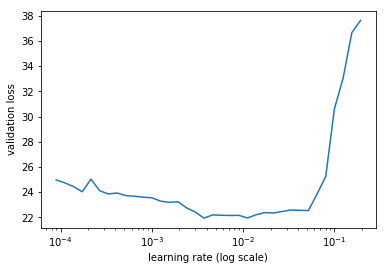

In [29]:
learn.lr_find()
learn.sched.plot()

In [45]:
learn.fit(1e-3, 3)

epoch      trn_loss   val_loss                            
    0      7.653821   6.646587  
    1      6.334069   5.693085                            
    2      5.652      5.258068                            



[array([5.25807])]

In [46]:
print_score()

0.1311624649859944


In [47]:
learn.unfreeze()

In [48]:
lr = 1e-3
lrs = [lr/9,lr/3,lr]

In [49]:
learn.fit(lrs, 3, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      4.896044   4.049125  
    1      3.834441   3.653793                            
    2      3.356263   3.161766                            
    3      3.0479     3.181167                            
    4      2.81699    2.635943                            
    5      2.59515    2.471204                            
    6      2.438925   2.427787                            



[array([2.42779])]

In [50]:
print_score()

0.41687675070028013


In [51]:
learn.fit(lrs, 3, cycle_mult=2)
print_score()

epoch      trn_loss   val_loss                            
    0      2.606639   2.721329  
    1      2.452897   2.380941                            
    2      2.422251   2.448992                            
    3      2.286885   2.472942                            
    4      2.155904   2.255905                            
    5      2.1091     2.339269                            
    6      1.982161   2.070993                            

0.5021008403361346


In [52]:
pos_imp=50
lr = 1e-4
lrs = [lr/9,lr/3,lr]

In [54]:
learn.fit(lrs, 3, cycle_mult=2)
print_score()

epoch      trn_loss   val_loss                            
    0      24.05526   23.809887 
    1      23.524791  23.597113                           
    2      23.519304  23.286486                           
    3      23.527896  23.450664                           
    4      23.473415  23.475355                           
    5      23.246161  23.096085                           
    6      22.711627  22.897357                           

0.6195640756302523


In [260]:
learn.save('toybox')

In [26]:
learn.load('toybox')

# Score 

In [25]:
nms_tresh = 0.05
keep_tresh = 0.2

nmss = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
keeps = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for n in nmss:
    for k in keeps:
        nms_tresh, keep_tresh = n,k
        preds = get_pred_boxes(learn.model, data.val_dl)
        sc = score_all(preds, data.val_ds.y)
        print(n,k,sc)

In [26]:
selections =np.zeros([189])
def pick_boxes(prob, boxes):
    to_keep = np.nonzero(prob>keep_tresh)
    selections[to_keep]+=1
    return (prob[to_keep], boxes[to_keep])


def nms(prob, boxes):
    removed = np.zeros(len(prob))
    idxs = np.flip(np.argsort(prob,0))
    for i,idx in enumerate(idxs):
        if removed[idx]: continue
        for j in range(i+1, len(idxs)):
            idx2 = idxs[j]
            if not removed[idx2] and IoU(BBox(*boxes[idx]), BBox(*boxes[idx2])) > nms_tresh:
                removed[idx2] = 1
    to_keep = (removed == 0)
    return (prob[to_keep], boxes[to_keep])
        

In [27]:
def get_pred_boxes(model, dl):
    model.eval()
    res = []
    for batch,_ in iter(dl):
        batch_prob, batch_box = model(V(batch))
        batch_prob = F.sigmoid(batch_prob)
        batch_prob = batch_prob.cpu().data.numpy()
        for prob, box in zip(batch_prob, batch_box):
            box = actn_to_bb(box, anchors).cpu().data.numpy() * 128
            prob = prob.reshape(-1)
            prob,box = pick_boxes(prob.reshape(-1),box )
            prob, picked = nms(prob,box)
            res.append(picked.reshape(-1))
    return res
#data.val_dl.batch_sampler.batch_size=128
preds = get_pred_boxes(learn.model, data.val_dl)

score_all(preds, data.val_ds.y)

0.14828431372549022

In [28]:
def print_score():
    preds = get_pred_boxes(learn.model, data.val_dl)
    print(score_all(preds, data.val_ds.y))

In [262]:
predsTTA = learn.TTA()

In [271]:
predsFromPredict = predict(learn.model, data.val_dl)
predsFromPredict.shape

(1000, 126, 1)

In [267]:
predsTTA[0].shape

(5, 1000, 126, 1)

In [269]:
predsTTA[0][0][0]

array([[-6.09246],
       [-6.1009 ],
       [-6.10913],
       [-6.09372],
       [-6.09427],
       [-6.08822],
       [-5.67836],
       [-7.04926],
       [-5.34932],
       [-4.90424],
       [-4.93936],
       [-4.48185],
       [-4.51563],
       [-5.18333],
       [-3.65226],
       [-3.64507],
       [-3.91285],
       [-3.49853],
       [-8.46502],
       [-9.01468],
       [-7.35038],
       [-9.39608],
       [-6.89224],
       [-7.88171],
       [-6.74985],
       [-7.6845 ],
       [-4.74171],
       [-7.82139],
       [-3.142  ],
       [-6.03734],
       [-5.40354],
       [-4.8757 ],
       [-3.8997 ],
       [-5.03191],
       [-3.13893],
       [-4.09775],
       [-5.21669],
       [-5.26993],
       [-3.39946],
       [-4.16715],
       [-2.77021],
       [-3.91034],
       [-4.39741],
       [-3.83875],
       [-2.6983 ],
       [-3.56053],
       [-1.74541],
       [-2.41726],
       [-2.58703],
       [-2.93461],
       [-2.20904],
       [-2.34507],
       [-2.3

# Debug

Variable containing:
 0.8750
 0.3750
[torch.cuda.FloatTensor of size 2 (GPU 0)]

Variable containing:
 0.1625
 0.0812
[torch.cuda.FloatTensor of size 2 (GPU 0)]

Variable containing:
 0.7937
 0.3344
 0.9563
 0.4156
[torch.cuda.FloatTensor of size 4 (GPU 0)]



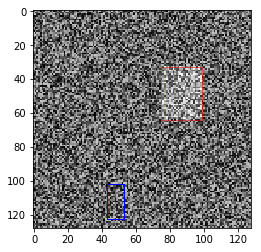

In [170]:
def show_anchor(anch_idx):
    actn_bbs = V(np.array([0,0,-1,-1],dtype=float))
    center = actn_bbs[:2]/2 * grid_sizes[anch_idx]+anchors[anch_idx,:2]
    actn_hw = (actn_bbs[2:]/2+1) * anchors[anch_idx,2:]
    ax = display(data.val_ds.fnames[2])
    print(center)
    print(actn_hw)
    corners = torch.cat([center-actn_hw/2, center+actn_hw/2])
    print(corners)
    draw_rect(ax,bb_hw(corners.cpu().data.numpy()*128),'blue')
    
show_anchor(124)


In [171]:
actn_bbs = np.array([0,0,0,0])
center = actn_bbs[:2]/2
grid_sizes[0]

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [49]:
a = T([1.0,2.0])
b = T([0.0, 3.0, 1.5, 1.5, 1.5,2.5])
b = b.view(-1,2)
l1 = a < b
l2 = a <b
l1,l2
ct =torch.cat([l1,l2],dim=1)
ct.min(1)[0]


 0
 0
 1
[torch.cuda.ByteTensor of size 3 (GPU 0)]

In [37]:
def fits_in_anchor(box, anch_idx):
    box /=128
    box_ctr = (box[:2]+box[2:])/2
    box_hw = (box[2:]-box[:2])
    anch_min_size = 0.5 * anchors[anch_idx,2:]
    anch_max_size = 1.5 * anchors[anch_idx,2:]
    size_fit = (box_hw >= anch_min_size) * (box_hw <=anch_max_size)
    min_center = -0.5 * grid_sizes[anch_idx,] + anchors[anch_idx,:2]
    max_center = 0.5 * grid_sizes[anch_idx,] + anchors[anch_idx,:2]
    center_fit = (box_ctr>=min_center) * (box_ctr <=max_center)
    #print(size_fit)
    #print(center_fit)
    return size_fit.all() and center_fit.all()

def fits_in_anchors(box):
    box /=128
    box_ctr = (box[:2]+box[2:])/2
    box_hw = (box[2:]-box[:2])
    anch_min_size = 0.3 * anchors[:,2:]
    anch_max_size = 1.7 * anchors[:,2:]
    size_fit = (box_hw >= anch_min_size) & (box_hw <=anch_max_size)
    min_center = -0.5 * grid_sizes + anchors[:,:2]
    max_center = 0.5 * grid_sizes + anchors[:,:2]
    center_fit = (box_ctr>=min_center) & (box_ctr <=max_center)
    both_fit = torch.cat([size_fit,center_fit],dim=1)
    both_fit = both_fit.min(1)[0]
    return torch.nonzero(both_fit).view(-1)

In [64]:
boxes_file = PATH/'../train_reversed_128.csv'
file2boxes = pd.read_csv(boxes_file)
file2boxes.set_index('patientId', inplace=True)
all_boxes =[]
for file_name ,row in file2boxes.iterrows():
    if not pd.isna(row['bboxes']):
        spl = row['bboxes'].split()
        for i in range(0,len(spl),4):
            box = np.array([float(spl[i]),float(spl[i+1]),float(spl[i+2]),float(spl[i+3])])
            if np.sum(box) > 0:
                all_boxes.append(box)
len(all_boxes)

8964

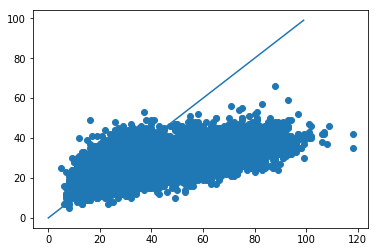

In [84]:
wh = [(box[2]-box[0], box[3]-box[1]) for box in all_boxes]
plt.scatter(*zip(*wh))
plt.plot(range(100), range(100))

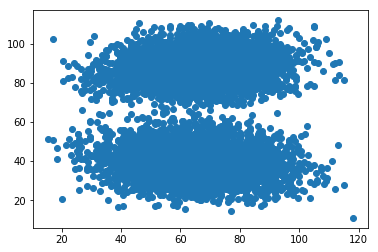

In [87]:
centers = [((box[2]+box[0])/2, (box[3]+box[1])/2) for box in all_boxes]
_,ax = plt.subplots(1)
ax.scatter(*zip(*centers))

In [211]:
anch_score = np.zeros(len(anchors))
box_coverage =[]
for box in all_boxes:

    fitting = fits_in_anchors(V(box))
    fitting = fitting.cpu().data.numpy()
    box_coverage.append(len(fitting))
    if(len(fitting>0)):
        anch_score[fitting]+=1
print(anch_score)

[   3.    0.    5.    2.   37.   13.   53.   40.   24.   10.   38.   28.    0.    0.    3.    0.   89.   13.
  195.  119.  589.  130. 1279.  886.  423.   92. 1042.  656.   68.   17.  156.   87.  204.   17.  360.  212.
 1020.  147. 1783. 1157.  600.   64. 1324.  700.  159.   26.  340.  177.   21.    2.   28.   18.   31.    4.
   57.   38.   27.    2.   51.   27.    8.    1.   19.    8. 1820. 1542. 1804. 2015. 1470. 1160. 1530. 1708.
 2353. 1964. 1945. 2202. 1938. 1484. 1974. 2110. 5710. 7176.  538. 4288.]


(array([   1.,   16.,   57.,   36.,  218., 1519., 1714., 2192., 2127.,  954.,   45.,   30.,   18.,   11.,
          10.,   10.,    6.,    0.,    0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 <a list of 19 Patch objects>)

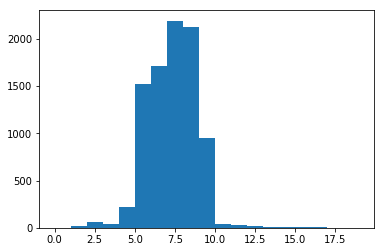

In [212]:
plt.hist(box_coverage,range(20))

In [213]:
np.nonzero(np.array(box_coverage)==0)

(array([2958]),)

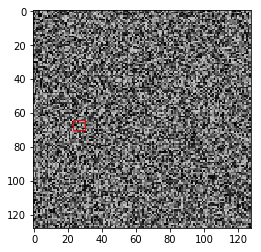

In [135]:
ax = display(data.val_ds.fnames[1])
draw_rect(ax, bb_hw(all_boxes[3276]))

In [127]:
fits_in_anchors(V(np.array([52., 87., 61., 98.])))

Variable containing:
 36
 37
[torch.cuda.LongTensor of size 2 (GPU 0)]

In [94]:
len(anchors)

126

In [104]:
small = np.nonzero(anch_score < 10)
small

(array([  0,   1,   2,   3,   4,   5,  13,  18,  19,  20,  21,  22,  23,  73,  75,  79,  85,  90,  91,  93,
         95, 122, 124]),)

In [268]:
cov_counts=[x[1] for x in box_coverage]
sorted(cov_counts)

[1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


In [35]:
x,y = next(iter(data.val_dl))
act = learn.model(V(x))

In [38]:
idx=2
activ0p =act[0][idx]
activ0b = act[1][idx]
tar_box0 = V(y)[idx]
activ0p = F.sigmoid(activ0p)
prob = activ0p.cpu().data.numpy().reshape(-1)
#anch_fit = [fits_in_anchor(tar_box0[:4], idx) for idx in range(189)]
#print(np.nonzero(anch_fit))
print(fits_in_anchors(tar_box0[:4]))
print(fitting_anchors(tar_box0[:4]))
#print(prob[np.nonzero(anch_fit)])
act_boxes =actn_to_bb(activ0b, anchors)*128
act_boxes = act_boxes.cpu().data.numpy()
#print(prob)

act_boxes = act_boxes[np.nonzero(prob>0.4)]
print(np.nonzero(prob>0.4))
filename = data.val_ds.fnames[idx]
ax =display(filename)
#draw_boxes(ax, anch_boxes, color='white')
draw_rects(ax,act_boxes.reshape(-1), 'blue')

Variable containing:
  36
  38
  39
  40
  41
 102
 103
 104
 105
 107
 121
[torch.cuda.LongTensor of size 11 (GPU 0)]



NameError: name 'fitting_anchors' is not defined

In [39]:
ssd_1_loss(activ0b, activ0p, tar_box0)

(Variable containing:
  0.2406
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  1.0906
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


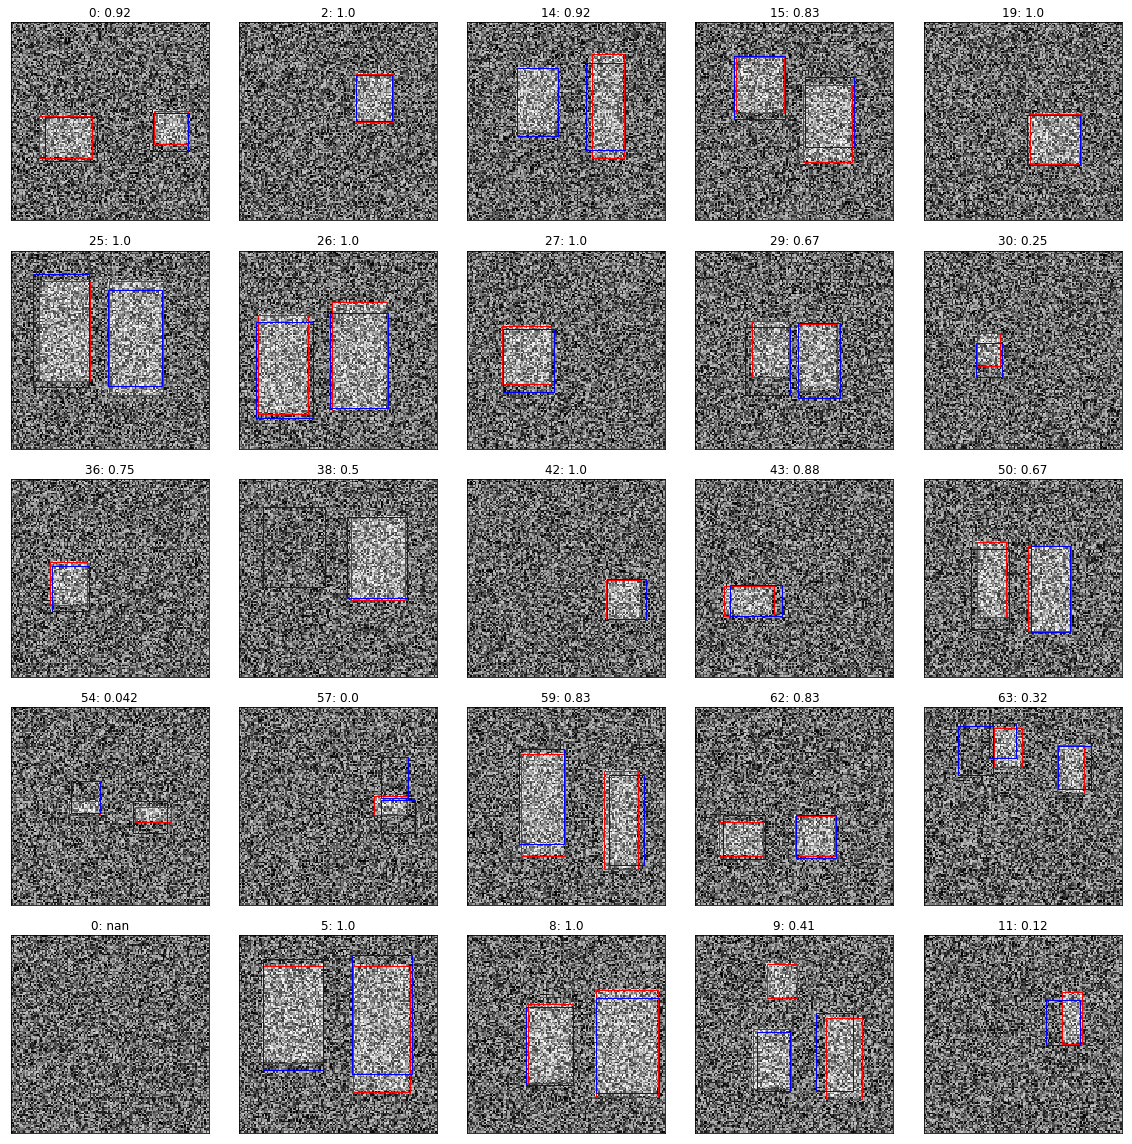

In [175]:
val_it = iter(data.val_dl)
x,y=next(val_it)
_,axs = plt.subplots(5,5,figsize=(16,16))
axs = axs.flatten()
idx=0
denx = data.val_ds.denorm(to_np(x))
y = to_np(y)
batch_no=0
for ax in axs:
    while idx < bs and y[idx][0]==0 :idx +=1
    if idx == bs:
        idx = 0
        batch_no = batch_no + 1
        x,y=next(val_it)
        denx = data.val_ds.denorm(to_np(x))
        y = to_np(y)
    ima=denx[idx]
    sc = score(ar2boxes(preds[batch_no * bs + idx]), ar2boxes(y[idx]))
    ax.set_title(f'{idx}: {sc:.2}')
    show_prediction(ima,preds[batch_no * bs + idx], y[idx], ax)
    idx+=1
plt.tight_layout()

# See augmentations

[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[29. 70. 71. 96. 20. 27. 87. 49.  0.  0.  0.  0.  0.  0.  0.  0.]
[27. 67. 71. 96. 21. 24. 90. 50.  0.  0.  0.  0.  0.  0.  0.  0.]
[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[27. 68. 71. 96. 21. 24. 89. 49.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  30.  72.  58.  18.  78.  86. 102.   0.   0.   0.   0.   0.   0.   0.   0.]


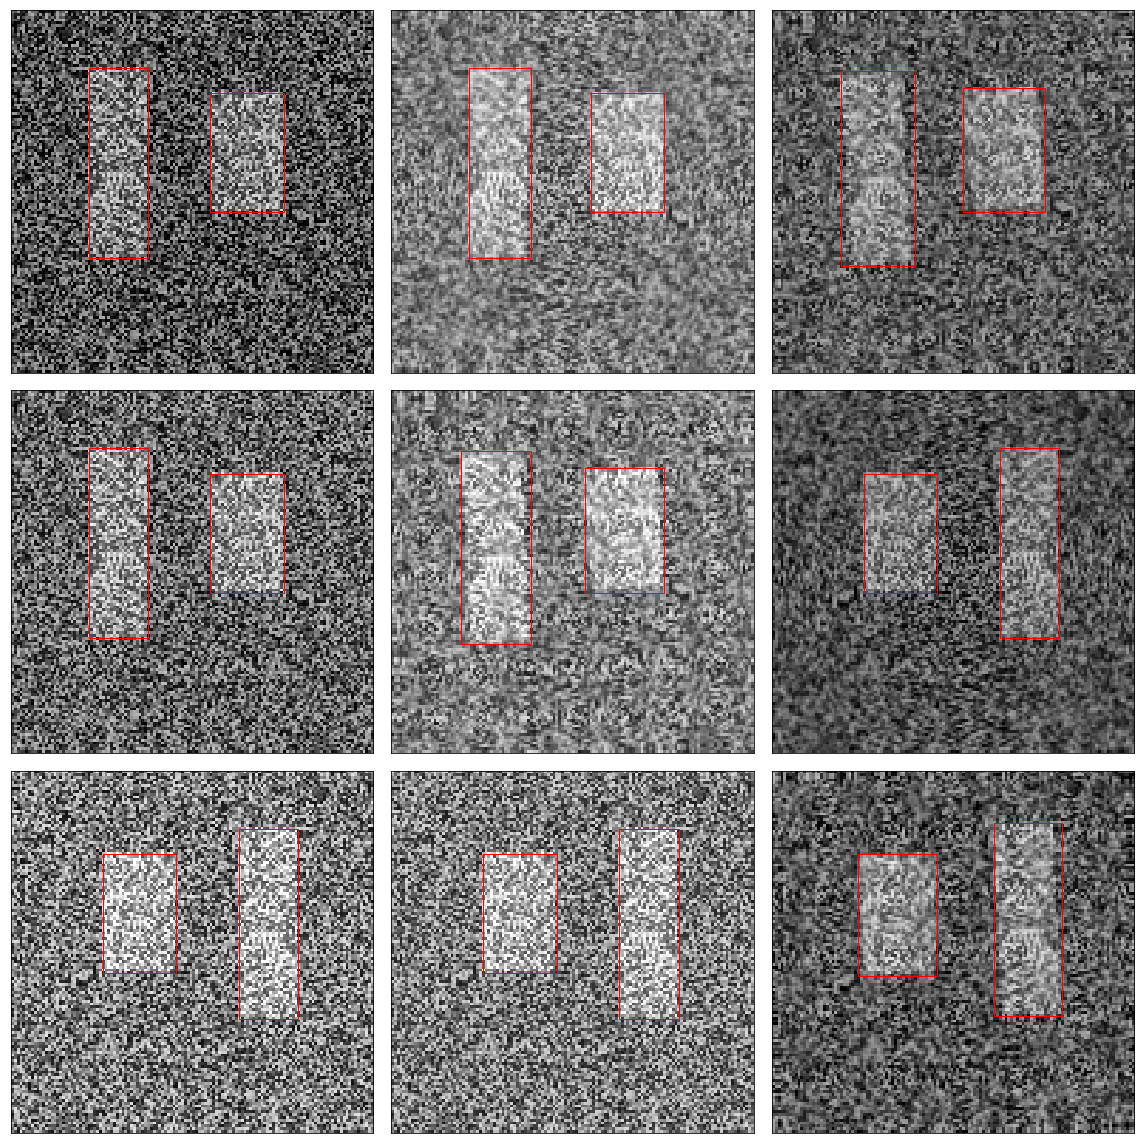

In [35]:
idx=14
fig,axes = plt.subplots(3,3, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(data.aug_dl))
    ima=data.val_ds.denorm(to_np(x))[idx]
    b = to_np(y[idx])
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, bb_hw(b[0:4]))
    draw_rect(ax, bb_hw(b[4:8]))
    draw_rect(ax, bb_hw(b[8:12]))
plt.tight_layout()